# Proyek Klasifikasi Gambar: [Handwritten Math Symbols]
- **Nama:** [Bagas Rizky Ramadhan]
- **Email:** [bagasramadhan@apps.ipb.ac.id]
- **ID Dicoding:** [mc001d5y1201]

## Import Semua Packages/Library yang Digunakan

In [17]:
# Impor pustaka utama TensorFlow dan komponen dari Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Untuk mount Google Drive
from google.colab import drive
from google.colab import files

# Data Augmentation dan Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/dataset'

Mounted at /content/drive


## Data Preparation

In [4]:
# Inisialisasi generator dengan normalisasi dan pemisahan validasi
datagen = ImageDataGenerator(
    rescale=1./255,   # Normalisasi piksel gambar dari [0, 255] ke [0, 1]
    validation_split=0.2   # Membagi dataset: 80% training, 20% validasi
)

# Generator data pelatihan
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),  # Ukuran input model
    batch_size=32,
    class_mode='categorical',
    subset='training'  # 80% untuk training
)
# Generator data validasi
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # 20% untuk validasi
)

# Generator data uji (tanpa augmentasi, hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8065 images belonging to 19 classes.
Found 2006 images belonging to 19 classes.
Found 10071 images belonging to 19 classes.



### 📌 **Pra-pemrosesan Data**

Dalam tahap ini, kita akan menggunakan fungsi `tf.keras.utils.image_dataset_from_directory` untuk memuat dataset gambar secara efisien. Fungsi ini memiliki beberapa keunggulan, yaitu:

* Mengimpor gambar dari struktur folder yang memiliki subdirektori per kelas.
* Secara otomatis menetapkan label berdasarkan nama folder.
* Menyelaraskan ukuran gambar menjadi seragam, sehingga perbedaan resolusi antar file tidak menjadi masalah.
* Memungkinkan pembagian dataset menjadi data pelatihan dan validasi.
* Secara default membuat data dalam bentuk batch agar siap digunakan dalam pelatihan model.



### 📌 **Pembangunan Model**

Model yang akan dibangun adalah jaringan saraf konvolusional (CNN) berbasis `Sequential`. Komponen-komponen utama model mencakup:

* Lapisan `Rescaling` yang berfungsi untuk menormalkan nilai piksel dari rentang 0–255 ke 0–1.
* Beberapa lapisan konvolusi (`Conv2D`) yang disertai dengan `MaxPooling2D` untuk mengekstraksi dan mereduksi fitur penting dari citra.
* Lapisan `Flatten` untuk mengubah hasil ekstraksi fitur menjadi vektor satu dimensi.
* Beberapa lapisan `Dense` untuk proses klasifikasi lanjutan.
* Lapisan `Dropout` digunakan untuk mengurangi risiko overfitting selama proses pelatihan.
* Lapisan output `Dense` dengan fungsi aktivasi `softmax`, yang digunakan untuk menentukan prediksi akhir dari beberapa kelas yang tersedia


## Modelling

In [7]:
# Inisialisasi model Sequential
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Mencegah overfitting
    Dense(19, activation='softmax')  # 19 kelas
])

# Inisialisasi Model untuk Pelatihan
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan struktur dan jumlah parameter model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,651 (2.62 MB)

 Trainable params: 685,651 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

### 🔁 **Callback**

Pada tahap pelatihan, kita menerapkan beberapa *callback* penting untuk meningkatkan efisiensi dan kualitas model:

* **ModelCheckpoint**: Digunakan untuk menyimpan versi terbaik dari model secara otomatis selama proses pelatihan, berdasarkan performa tertinggi pada data validasi.
* **EarlyStopping**: Berfungsi untuk menghentikan proses pelatihan lebih awal apabila tidak terjadi peningkatan akurasi validasi dalam beberapa *epoch* berturut-turut, sehingga menghindari pelatihan yang berlebihan (*overfitting*) dan menghemat waktu komputasi.




In [8]:
# EarlyStopping: hentikan pelatihan jika akurasi validasi tidak membaik dalam 5 epoch berturut-turut
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# ModelCheckpoint: simpan model terbaik selama pelatihan
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

In [9]:
# Mulai proses pelatihan model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2443 - loss: 2.4478

253/253 ━━━━━━━━━━━━━━━━━━━━ 2384s 9s/step - accuracy: 0.2449 - loss: 2.4457 - val_accuracy: 0.7777 - val_loss: 0.7982
Epoch 2/25
252/253 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6931 - loss: 0.9729

253/253 ━━━━━━━━━━━━━━━━━━━━ 133s 366ms/step - accuracy: 0.6933 - loss: 0.9722 - val_accuracy: 0.8848 - val_loss: 0.4158
Epoch 3/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7869 - loss: 0.6764

253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - accuracy: 0.7870 - loss: 0.6762 - val_accuracy: 0.9172 - val_loss: 0.2826
Epoch 4/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8232 - loss: 0.5291

253/253 ━━━━━━━━━━━━━━━━━━━━ 92s 363ms/step - accuracy: 0.8232 - loss: 0.5289 - val_accuracy: 0.9352 - val_loss: 0.2151
Epoch 5/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8952 - loss: 0.3220

253/253 ━━━━━━━━━━━━━━━━━━━━ 91s 360ms/step - accuracy: 0.8953 - loss: 0.3220 - val_accuracy: 0.9477 - val_loss: 0.1680
Epoch 6/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9069 - loss: 0.2852

253/253 ━━━━━━━━━━━━━━━━━━━━ 101s 398ms/step - accuracy: 0.9069 - loss: 0.2852 - val_accuracy: 0.9482 - val_loss: 0.1737
Epoch 7/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9156 - loss: 0.2466

253/253 ━━━━━━━━━━━━━━━━━━━━ 103s 407ms/step - accuracy: 0.9157 - loss: 0.2465 - val_accuracy: 0.9526 - val_loss: 0.1497
Epoch 8/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.9382 - loss: 0.1834 - val_accuracy: 0.9447 - val_loss: 0.1803
Epoch 9/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9416 - loss: 0.1830

253/253 ━━━━━━━━━━━━━━━━━━━━ 88s 349ms/step - accuracy: 0.9416 - loss: 0.1830 - val_accuracy: 0.9606 - val_loss: 0.1393
Epoch 10/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 89s 350ms/step - accuracy: 0.9542 - loss: 0.1388 - val_accuracy: 0.9556 - val_loss: 0.1556
Epoch 11/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 88s 349ms/step - accuracy: 0.9520 - loss: 0.1307 - val_accuracy: 0.9551 - val_loss: 0.1467
Epoch 12/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 141s 347ms/step - accuracy: 0.9419 - loss: 0.1752 - val_accuracy: 0.9606 - val_loss: 0.1339
Epoch 13/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9629 - loss: 0.1074

253/253 ━━━━━━━━━━━━━━━━━━━━ 91s 358ms/step - accuracy: 0.9629 - loss: 0.1074 - val_accuracy: 0.9631 - val_loss: 0.1377
Epoch 14/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 99s 391ms/step - accuracy: 0.9673 - loss: 0.0934 - val_accuracy: 0.9591 - val_loss: 0.1480
Epoch 15/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9695 - loss: 0.0855

253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - accuracy: 0.9695 - loss: 0.0855 - val_accuracy: 0.9716 - val_loss: 0.1016
Epoch 16/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 99s 391ms/step - accuracy: 0.9759 - loss: 0.0736 - val_accuracy: 0.9666 - val_loss: 0.1179
Epoch 17/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 357ms/step - accuracy: 0.9740 - loss: 0.0747 - val_accuracy: 0.9666 - val_loss: 0.1240
Epoch 18/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 98s 387ms/step - accuracy: 0.9722 - loss: 0.0856 - val_accuracy: 0.9661 - val_loss: 0.1183
Epoch 19/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 100s 394ms/step - accuracy: 0.9728 - loss: 0.0726 - val_accuracy: 0.9696 - val_loss: 0.1207
Epoch 20/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - accuracy: 0.9793 - loss: 0.0621 - val_accuracy: 0.9681 - val_loss: 0.1088


## Evaluasi dan Visualisasi

315/315 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9937 - loss: 0.0275
Akurasi pada test set: 99.38%


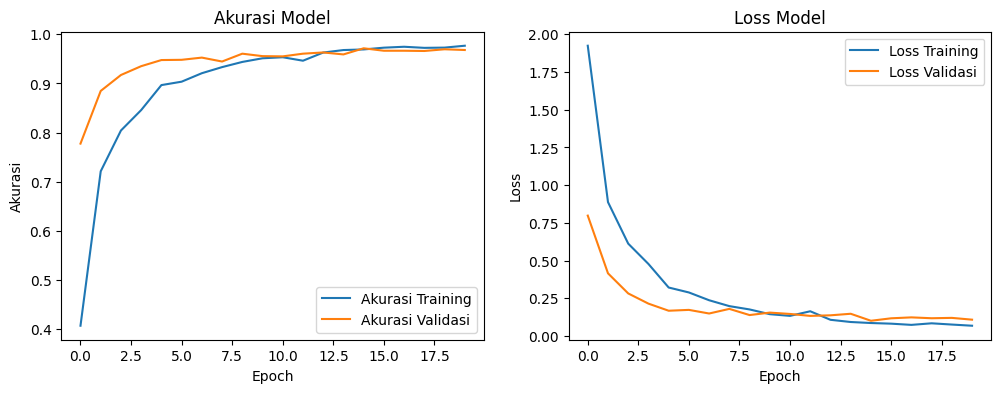

In [11]:
# Evaluasi performa model pada data uji
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi pada test set: {test_accuracy*100:.2f}%")

# Visualisasi akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [14]:
# #️⃣ MEMBUAT DIREKTORI PENYIMPANAN
os.makedirs('/content/saved_model', exist_ok=True)
os.makedirs('/content/tflite', exist_ok=True)
os.makedirs('/content/tfjs_model', exist_ok=True)

# a. SIMPAN MODEL DALAM FORMAT SavedModel (untuk TF Serving atau deployment lanjut)
saved_model_path = '/content/saved_model'
model.export(saved_model_path)
print(f"Model berhasil disimpan dalam format SavedModel di: {saved_model_path}")

# b. KONVERSI MODEL KE FORMAT TFLITE (untuk digunakan di perangkat mobile / edge)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = '/content/tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Simpan nama label kelas (untuk inferensi di sisi pengguna)
class_names = list(train_generator.class_indices.keys())
label_path = '/content/tflite/label.txt'
with open(label_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")
print(f"Model dan label berhasil disimpan dalam format TF-Lite di: /content/tflite")

# c. KONVERSI MODEL KE FORMAT TENSORFLOW.JS (untuk aplikasi web)
!pip install tensorflowjs -q
import tensorflowjs as tfjs

tfjs_model_path = '/content/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_model_path)
print(f"Model berhasil disimpan dalam format TFJS di: {tfjs_model_path}")

# KOMPRES SEMUA MODEL MENJADI ZIP UNTUK DIDOWNLOAD
zip_path = '/content/models.zip'
!zip -r {zip_path} /content/saved_model /content/tflite /content/tfjs_model
print(f"Semua model dikompresi ke: {zip_path}")

# UNDUH FILE SECARA OTOMATIS
files.download(zip_path)

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  136791994085072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994085840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994085456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994088720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994087952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994088144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994089104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791994085264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791975363600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791975365136: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasi

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TFJS di: /content/tfjs_model
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 85%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/variables/variables.index (deflated 62%)
  adding: content/tflite/ (stored 0%)
  adding: content/tflite/label.txt (stored 0%)
  adding: content/tflite/model.tflite (deflated 7%)
  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 85%)
Semua model dikompresi ke: /content/models.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

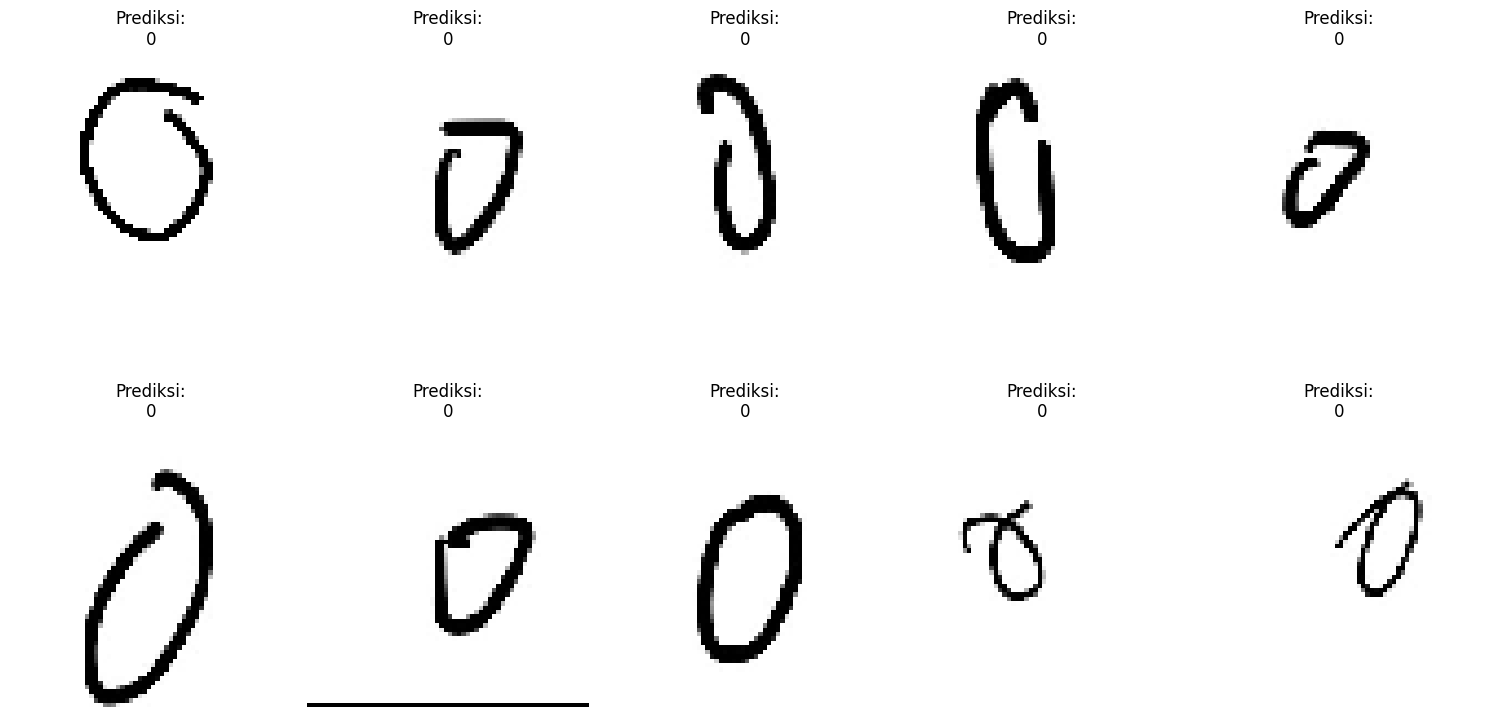

In [16]:
# 1. LOAD MODEL TFLITE DAN INISIALISASI
interpreter = tf.lite.Interpreter(model_path='/content/tflite/model.tflite')
interpreter.allocate_tensors()

# 2. AMBIL INFORMASI TENSOR INPUT DAN OUTPUT
input_info = interpreter.get_input_details()
output_info = interpreter.get_output_details()

# 3. AMBIL SAMPEL DATA UJI UNTUK PREDIKSI
num_samples = 10
images_batch, labels_batch = next(test_generator)
selected_images = images_batch[:num_samples]

# 4. SIAPKAN LABEL KELAS
label_names = list(train_generator.class_indices.keys())
tflite_predictions = []

# 5. INFERENSI MANUAL PER GAMBAR
for img in selected_images:
    input_array = np.expand_dims(img, axis=0)  # Tambahkan dimensi batch (1, 64, 64, 3)
    interpreter.set_tensor(input_info[0]['index'], input_array)
    interpreter.invoke()
    output_array = interpreter.get_tensor(output_info[0]['index'])
    predicted_index = np.argmax(output_array[0])
    tflite_predictions.append(label_names[predicted_index])

# 6. VISUALISASI HASIL PREDIKSI
plt.figure(figsize=(15, 8))
for idx, img in enumerate(selected_images):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Prediksi:\n{tflite_predictions[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
!pip freeze > /content/requirements.txt